# Восстановление золота из руды

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
# чтение файла с данными и сохранение в df с использованием конструкции try-except
try:
    df_train = pd.read_csv('C:/Users/datasets/gold_recovery_train_new.csv') # локальный путь
    df_test = pd.read_csv('C:/Users/datasets/gold_recovery_test_new.csv')
    df_full = pd.read_csv('C:/Users/datasets/gold_recovery_full_new.csv')
except:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv') # серверный путь
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
# просмотр первых пяти строк обучающей выборки
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
# получение общей информации об обучающей выборки
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
# просмотр первых пяти строк тестовой выборки
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
# получение общей информации о тестовой выборки
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [7]:
# просмотр первых пяти строк исходных данных
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
# получение общей информации об исходных данных
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Таким образом, у нас имеются три датасета, в которых присутствуют пропуски. Все признаки имеют тип `float64`. В тестовой выборке отсутствуют некоторые признаки. 

Теперь проверим, правильно ли рассчитана эффективность обогащения. Для этого вычилслим MAE между нашими расчётами и значением признака `rougher.output.recovery`.

In [9]:
# расчет абсолютной средней ошибки
recovery = df_train['rougher.output.concentrate_au']*(
df_train['rougher.input.feed_au']-df_train['rougher.output.tail_au']) / (
df_train['rougher.input.feed_au']*(df_train['rougher.output.concentrate_au']-df_train['rougher.output.tail_au']))*100 # расчет эффективности обогащения

print('Абсолютная средняя ошибка =', mean_absolute_error(df_train['rougher.output.recovery'], recovery)) # рассчет MAE

Абсолютная средняя ошибка = 9.73512347450521e-15


Абсолютная средняя ошибка очень мала, что говорит о том, что эффективность обогащения рассчитана правильно.

Посмотрим, какие признаки есть в обучающей выборке, но при этом отустствуют в тестовой.

In [10]:
# признаки, отсутствующие в тестовой выборке
list_train = df_train.columns.values.tolist()
list_test = df_test.columns.values.tolist()
for col in list_train:
    if col not in list_test:
        print(col)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

Согласно полученным результатам, в тестовой выборке нет столбцов с этапами `final.output`, `primary_cleaner.output`, `rougher.calculation`, `rougher.output` и `secondary_cleaner.output`. Данные этих столбцов являются онлайн метриками, так как замеряются и/или рассчитываются значительно позже (по результатам технологического процесса). Остальные признаки относятся к офлайн метрикам, поскольку исторически известны.

В тестовой выборке отсутствуют два целевых признака: `rougher.output.recovery` и `final.output.recovery`. Добавим их в датасет из исходной таблицы.

In [11]:
# добавление целевых признаков в df_test
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how = 'inner', on='date')
df_test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909,95.172585,68.919891
5286,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761,94.575036,68.440582
5287,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882,93.018138,67.092759
5288,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284,92.599042,68.061186


Так как данные индексируются датой и временем получения информации, то соседние по времени параметры часто похожи. Поэтому заполним пропуски соседними значениями.

In [12]:
# заполнение пропусков
df_train = df_train.fillna(method='ffill')
print('Количество пропусков в обучающей выборке:', df_train.isna().sum().sum())

df_test = df_test.fillna(method='ffill')
print('Количество пропусков в тестовой выборке:', df_test.isna().sum().sum())

Количество пропусков в обучающей выборке: 0
Количество пропусков в тестовой выборке: 0


## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки, построив гистограммы.

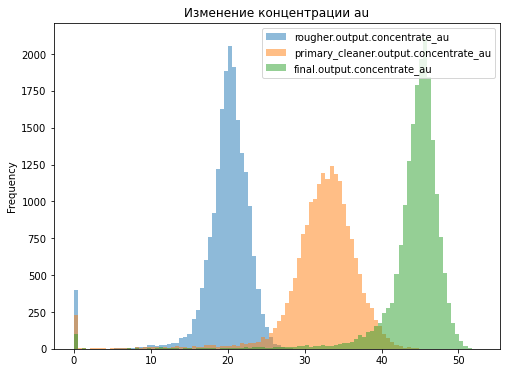

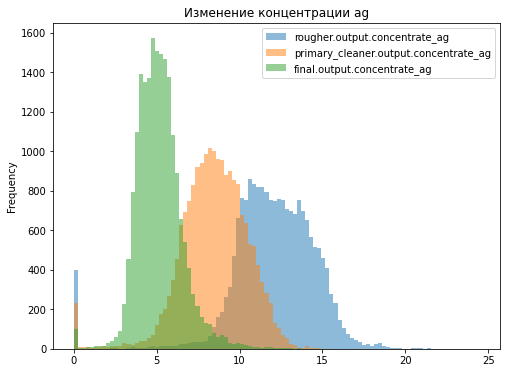

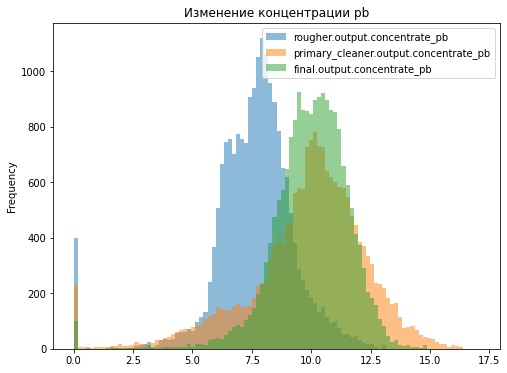

In [13]:
# гистограммы изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки
metals = ['au', 'ag', 'pb']
concentrate = ['rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate',]
for metal in metals:
    phase = ['{}_{}'.format(x, metal) for x in concentrate]
    df_full[phase].plot(kind='hist', bins=100, figsize=(8, 6), alpha=0.5)
    plt.title('Изменение концентрации {}'.format(metal))
    plt.show()

Концентрация золота увеличивается на каждом этапе очистки, а концентрация серебра наоборот падает, уже начиная с этапа rouger. Концентрация свинца увеличивается на протяжении всех этапов, но не так сильно как концентрация золота. 

Теперь сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

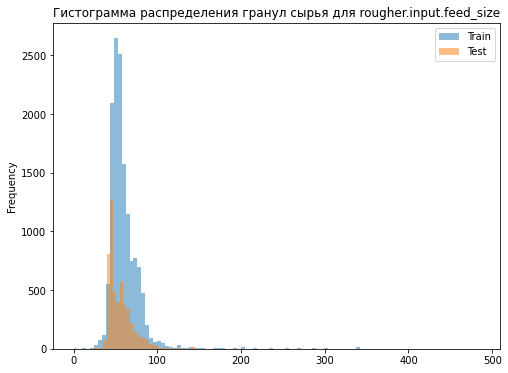

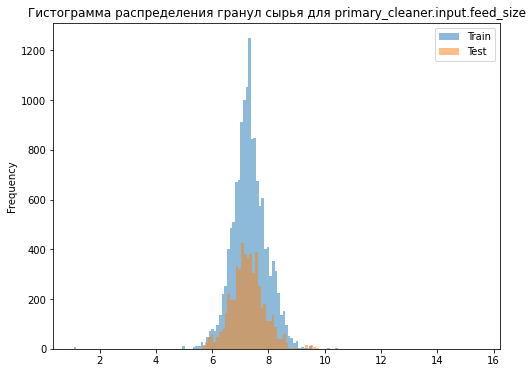

In [14]:
# гистограмма распределения гранул сырья перед флотацией и первичной очисткой
feed_size = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']
data = [(df_train, 'Train'), (df_test, 'Test')]
for size in feed_size:
    for df, lab in data: 
        df[size].plot(kind='hist', bins=100, figsize=(8, 6), alpha=0.5, label='{}'.format(lab), legend=True)
    plt.title('Гистограмма распределения гранул сырья для {}'.format(size)) 
    plt.show()

Исходя из построенных графиков, можно сделать вывод, что распределения размеров гранул сырья на обучающей и тестовой выборках совпадают, а следоватьельно оценка модели будет правильной.

С целью выявления аномалий найдем суммарную концентрацию всех веществ (металлы плюс sol) на разных стадиях: в сырье, в черновом и финальном концентратах.

In [15]:
# подсчет суммарной концентрации всех веществ на разных стадиях
substances = ['au', 'ag', 'pb', 'sol']
for phase in concentrate:
    df_train[phase] = 0
    for substance in substances:
        df_train[phase] += df_train['{}_{}'.format(phase, substance)]
    
df_train[concentrate].head()

,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
0,66.424950,72.640924,63.644396
1,67.012710,72.543485,63.957723
2,66.103793,72.095042,64.311180
3,65.752751,59.957723,63.573449
4,65.908382,71.321010,64.004667


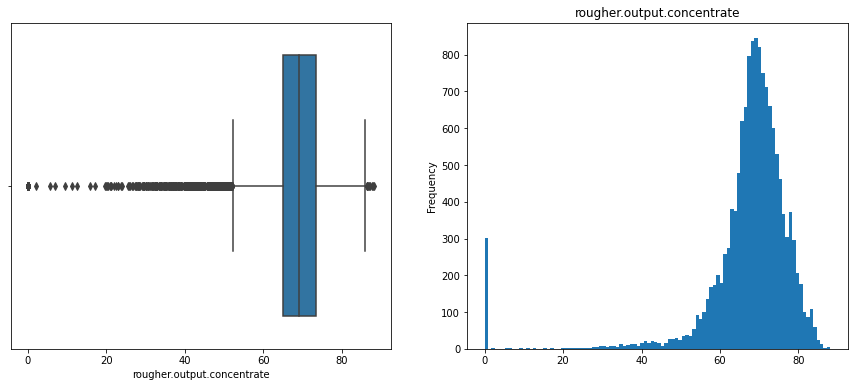

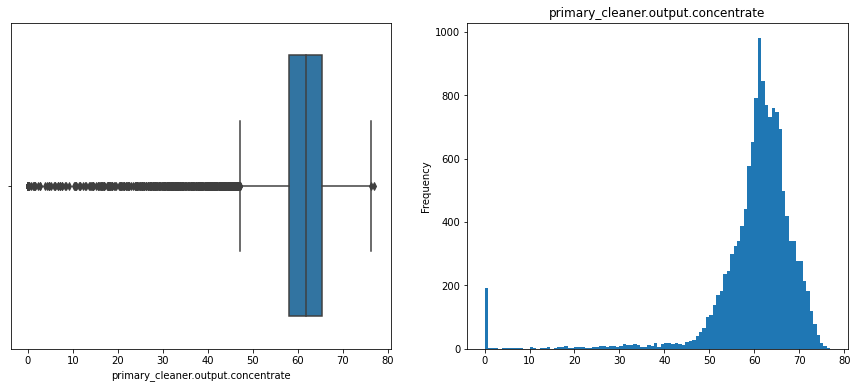

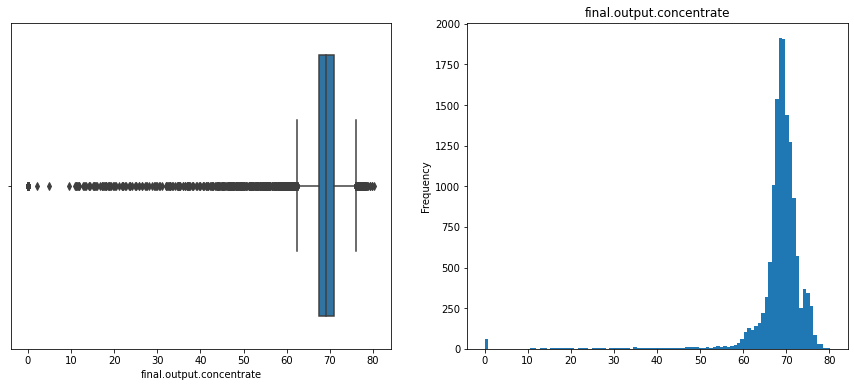

In [16]:
# диаграмма размаха и гистограмма суммарной концентрации на разных стадиях
for phase in concentrate:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.boxplot(x=df_train[phase], ax=axes[0])
    
    df_train[phase].plot(kind='hist', bins=100, ax=axes[1])
    plt.title('{}'.format(phase))
    plt.show()

На графиках видно, что есть нулевые значения. Удалим их из обучающей выборки. 

In [17]:
# удаления строк с нулевыми значениями суммарной концентрации
df_train = df_train[(df_train['rougher.output.concentrate'] !=0) & (df_train['primary_cleaner.output.concentrate'] !=0)
                    & (df_train['final.output.concentrate'] !=0)]
df_train.shape

(13725, 90)

## Модель

Удалим из обучающей выборки лишние признаки из train, те, что отуствуют в тестовой.

In [18]:
# удаление признаков
col_to_delete = set(df_train.columns.to_list()) - set(df_test.columns.to_list())
df_train = df_train.drop(col_to_delete, axis='columns')
df_train.shape

(13725, 55)

Итак, мы получили в обучающей и тестовой выборке одни и те же признаки.

Теперь напишем функцию для вычисления итоговой sMAPE.

In [20]:
# функция для вычисления итоговой sMAPE
def cal_smape(y_true, y_pred):
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2
    result = (error / scale).mean()
    return result*100
 

def final_smape(y_true, y_pred):
    y_true.reset_index(drop=True, inplace=True)
    y_pred = pd.DataFrame(data=y_pred)
    rougher = cal_smape(y_true.iloc[:, 0], y_pred.iloc[:, 0])
    final = cal_smape(y_true.iloc[:, 1], y_pred.iloc[:, 1])
    return 0.25 * rougher + 0.75 * final

Выделим для тестовой и обучающей выборок признаки и целевые признаки.

In [21]:
# подготовка признаков для тестовой выборки
target = ['rougher.output.recovery', 'final.output.recovery']
target_train = df_train[target]
features_train = df_train.drop(target, axis=1, inplace=True)
features_train = df_train.drop('date', axis=1)


# подготовка признаков для обучающей выборки
target_test = df_test[target]
features_test = df_test.drop(target, axis=1, inplace=True)
features_test = df_test.drop('date', axis=1)

In [22]:
# проверка
print(target_train.columns)
print(features_train.shape)
print(target_test.columns)
print(features_test.shape)

Index(['rougher.output.recovery', 'final.output.recovery'], dtype='object')
(13725, 52)
Index(['rougher.output.recovery', 'final.output.recovery'], dtype='object')
(5290, 52)


Создадим переменную smape_scorer, чтобы в дальнейшем использовать ее при кросс-валидации, воспользовшись функцией `make_scorer`.

In [23]:
# создание переменной smape_scorer
smape_scorer = make_scorer(final_smape, greater_is_better=False)

Теперь перейдем к обучению и выбору лучшей модели.

In [24]:
# модель дерева решений
param_grid = {'max_depth': range(2, 15)}
model = DecisionTreeRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print('sMAPE для дерева решений: {} при значениях гиперпараметров: {}'.format(-search.best_score_, search.best_params_))

sMAPE для дерева решений: 9.174433066207342 при значениях гиперпараметров: {'max_depth': 2}


In [25]:
# модель случайного леса
param_grid = {'n_estimators': range(1, 31, 10)}
model = RandomForestRegressor(max_depth=2, random_state=12345)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print('sMAPE для случайного леса: {} при значениях гиперпараметров: {}'.format(-search.best_score_, search.best_params_))

sMAPE для случайного леса: 9.008149504729506 при значениях гиперпараметров: {'n_estimators': 21}


In [26]:
# модель линейной регрессии
model = LinearRegression()
model.fit(features_train, target_train)
smape = cross_val_score(model, features_train, target_train, cv=5, scoring=smape_scorer).mean()
print('sMAPE для линейной регрессии:', -smape)

sMAPE для линейной регрессии: 10.029323387636392


Наилучшая модель - RandomForestRegressor с гиперпараметрами max_depth=2 и n_estimators=21. Проверим ее на тестовой выборке, а также сравним качество предсказаний с константной моделью. За константу примем средние значения. 

In [28]:
# модель случайного леса на тестовой выборке
model = RandomForestRegressor(max_depth=2, n_estimators=21, random_state=12345) 
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

print('sMAPE для тестовой выборки:', final_smape(target_test, predictions_test))

sMAPE для тестовой выборки: 9.507179779602144


In [29]:
# константная модель
median_rougher = pd.Series([target_train['rougher.output.recovery'].median()]*len(target_train))
median_final = pd.Series([target_train['final.output.recovery'].median()]*len(target_train))

model = RandomForestRegressor(max_depth=2, n_estimators=21, random_state=12345) 
model.fit(features_train, target_train)
predictions_test_constant = pd.concat([median_rougher, median_final], axis=1)

print('sMAPE для константной модели:', final_smape(target_test, predictions_test_constant))

sMAPE для константной модели: 9.441580433776988


На тестовой выборке случайный лес показал значение sMAPE чуть выше, чем на обучающей (на 0,5). sMAPE для константной модели составило 9,44, что немного меньше значения метрики на тестовых данных на 0,06. Другими словами наша модель дает такую же точность ответов, как и константная модель.